<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Test-the-experiment-class" data-toc-modified-id="Test-the-experiment-class-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Test the experiment class</a></span></li><li><span><a href="#Initialize-experiment-as-a-PNN-module" data-toc-modified-id="Initialize-experiment-as-a-PNN-module-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Initialize experiment as a PNN module</a></span><ul class="toc-item"><li><span><a href="#Without-trainable-parameters-(only-trainable-inputs)" data-toc-modified-id="Without-trainable-parameters-(only-trainable-inputs)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Without trainable parameters (only trainable inputs)</a></span></li></ul></li><li><span><a href="#Train-differentiable-digital-model" data-toc-modified-id="Train-differentiable-digital-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train differentiable digital model</a></span><ul class="toc-item"><li><span><a href="#(Optional)-Test-digital-twin-on-unseen-data:" data-toc-modified-id="(Optional)-Test-digital-twin-on-unseen-data:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>(Optional) Test digital twin on unseen data:</a></span></li></ul></li><li><span><a href="#Define-PNN-module" data-toc-modified-id="Define-PNN-module-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Define PNN module</a></span></li><li><span><a href="#Train-PNN-module" data-toc-modified-id="Train-PNN-module-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train PNN module</a></span><ul class="toc-item"><li><span><a href="#Initialize-simple-dataset" data-toc-modified-id="Initialize-simple-dataset-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Initialize simple dataset</a></span></li><li><span><a href="#Initialize-model,-optimizer-and-scheduler" data-toc-modified-id="Initialize-model,-optimizer-and-scheduler-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Initialize model, optimizer and scheduler</a></span></li><li><span><a href="#Training-loop" data-toc-modified-id="Training-loop-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Training loop</a></span></li></ul></li><li><span><a href="#Visualize-results" data-toc-modified-id="Visualize-results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Visualize results</a></span></li></ul></div>

Pytorch training loop based on https://github.com/pytorch/examples/blob/master/mnist/main.py

In this example, we consider a physical neural network based on coupled pendula. In contrast with the first example, here we train the physical parameters of the coupled pendula system (see figure below). 

To do this, we need to use a more physics-based differentiable digital model that generalizes to a broader range of physical parameters more accurately than the deep neural network model used previously. To achieve this, we will use a data-driven calibration of physical controls to the parameters of the differential equations that describe the pendula. 

(While this example includes some care to be aware of experimental realities, we have simplified things somewhat in the interest of a tutorial example. We anticipate that for a real, experimental device, obtaining such a broadly-generalizable model will often require more effort. Nonetheless, extending the approach used here would be a good way to start!)

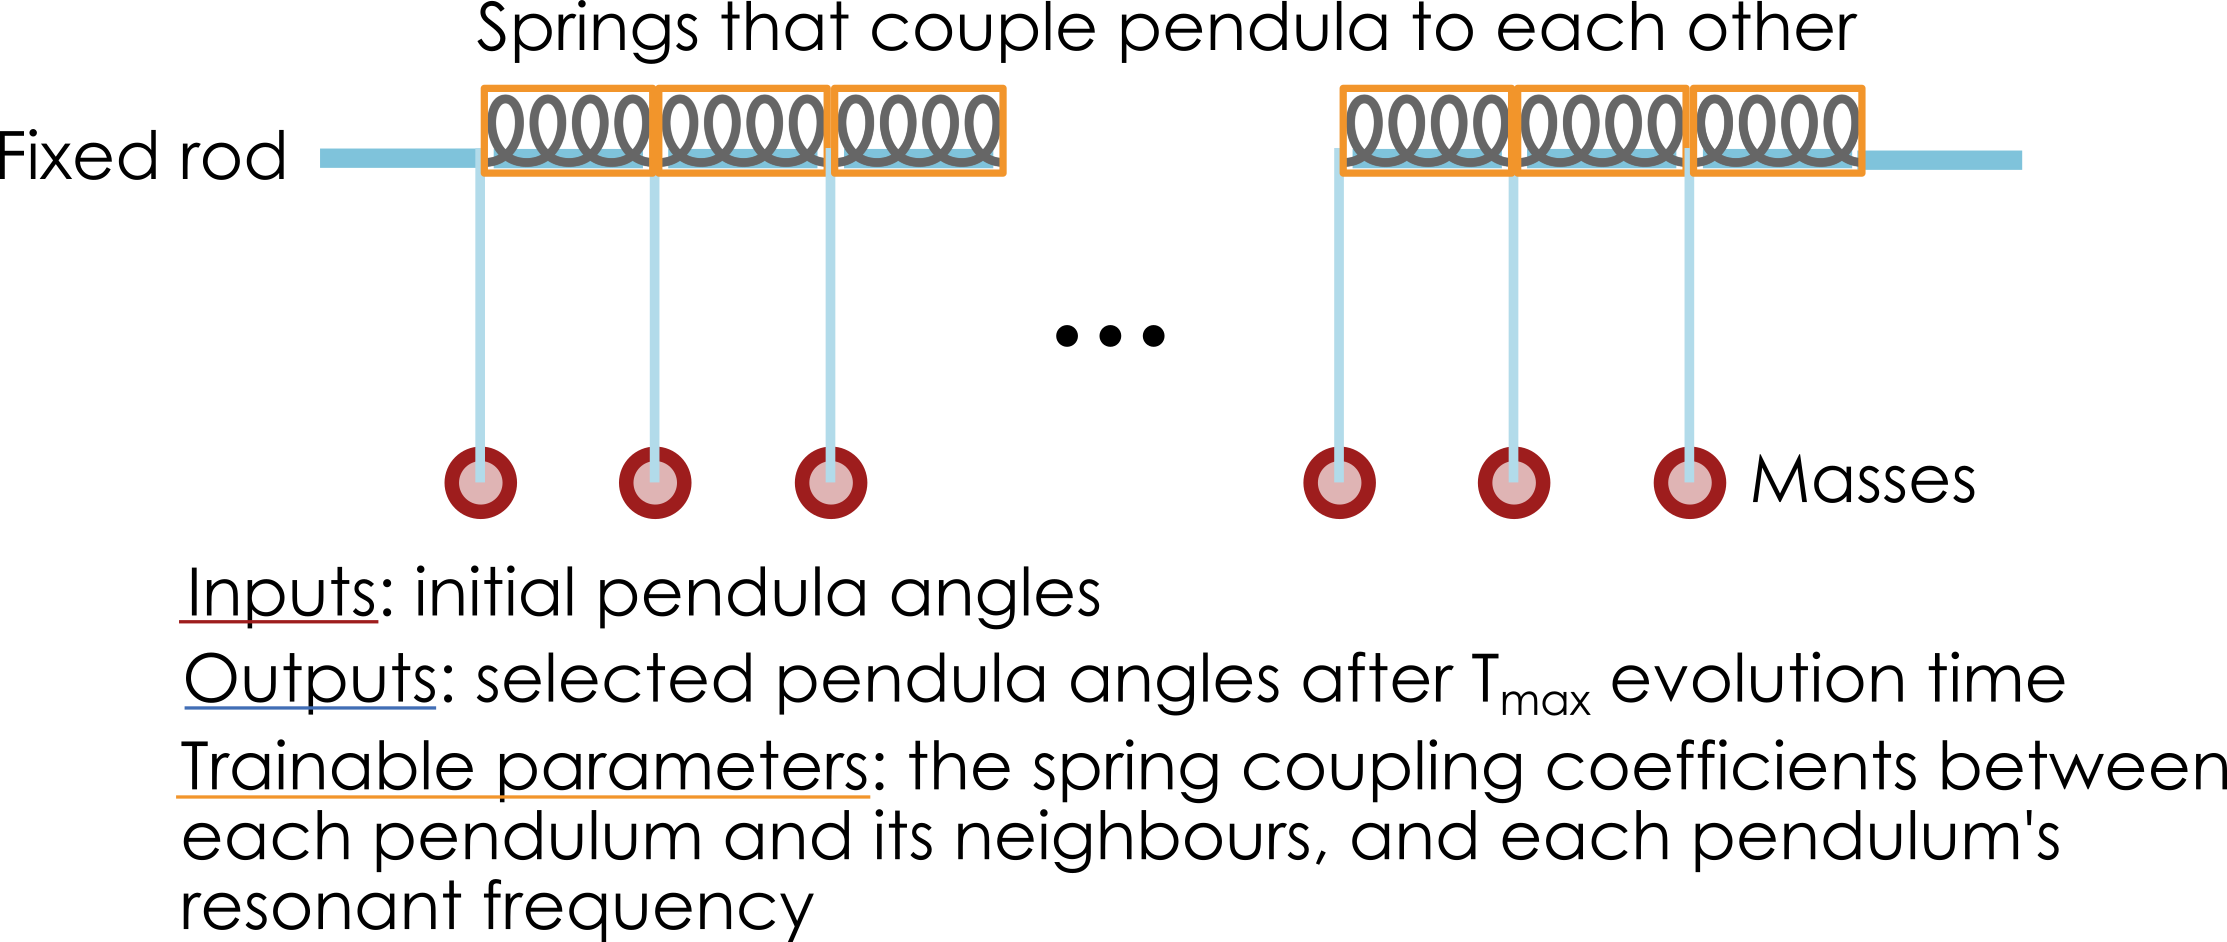

In [1]:
# standard python imports
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import copy

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [2]:
# temporary imports (delete before publication)
import ipdb
from importlib import reload  

def crazy_reload(package_string):
    exec(rf"import {package_string}")
    exec(rf"reload({package_string})")
    exec(rf"from {package_string} import *", globals())

In [3]:
# determine whether a GPU is available for training
use_cuda = torch.cuda.is_available()
# If a specific GPU should be used, change device name "cuda" to "cuda:0" or whichever number should be used
device = torch.device("cuda" if use_cuda else "cpu")
# set manual seed for replicability
torch.manual_seed(0)

## Test the experiment class

We import an experiment class CoupledPendula which is defined in exp.py.

In [4]:
from exp import CoupledPendula

Initialize an instance of the CoupledPendula experiment to test it:

In [5]:
pend = CoupledPendula(Tmax = 4)

Set all parameteres as defined in the experiment class and look at the dynamics:

In [6]:
# simulate a chain of coupled pendula with the following parameters
ω0 = torch.tensor([10.,10.,10.,10.])
ωd = torch.tensor([0.,0.,0.,0.])
Ad = torch.tensor([0.,0.,0.,0.])
v0 = torch.tensor([0.,0.,0.,0.])
coupling = torch.tensor([10.,10.,10.,10.])
γ = torch.tensor([0.,0.,0.,0.])
encoding_amplitude = torch.tensor(1.)
phid = torch.tensor([0.,0.,0.,0.])

# set initial angles (in rad)
x = torch.rand([1,4])*2 - 1
# propagate through setup
yout = pend(x, ω0, ωd, Ad, v0, coupling, γ, encoding_amplitude, phid, full = True)

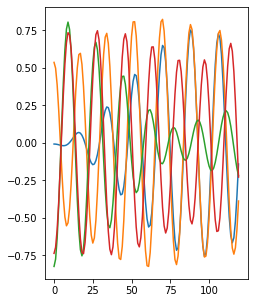

In [7]:
plt.figure(figsize = [8,5])
plt.subplot(1,2,1)
for i in range(4):
    plt.plot(yout.detach().cpu()[:, 0, i, 0])

The left graph shows all pendula moving in unison when starting from the same initial conditions.
The right graph shows the pendula swinging exacly out of phase and with increased frequency due to the coupling between them.

# Now, study the sensitivity of the dynamics to initial conditions and parameters

In order for a real experimental system to be modelled robustly by a digital model, it is necessary that the system's dynamics not be too sensitive to parameter values or initial conditions, such as occurs with chaotic dynamics. If the outputs depend too sensitively on the parameters or inputs, then different noise instantiations, or experimental errors, will lead to radically different outputs for a nominally-fixed input. For a useful physical neural network, we need the behavior of the physical system to be at least mostly deterministic with respect to inputs and parameters we control. 

Here, we will assume that it is possible to estimate the parameters of the experimental apparatus to within 1% of their true values. We will then show how, given initial guesses with this accuracy, a data-driven approach can be used to learn the values more precisely, and to facilitate using a differential equation model for the input-output transformation implemented by the system. 

We first examine the sensitivity of the pendula to initial conditions as different hyperparameters are changed, to ensure that we can tolerate this 1% uncertainty.

Here, we will vary the maximum amplitude of the inputs, which is the most direct way to vary the nonlinearity of the pendula dynamics. We find that reducing the maximum amplitude by a modest factor dramatically reduces the system's sensitivity to input conditions, to a point where it is reasonable to expect a digital model to accurately describe experiments. 

In [8]:
error = [] #store the error relative to the nominal true value 
amp_levels = np.linspace(0.1,2,30)

    # set initial angles (in rad)
x = torch.rand([1,4])*2 - 1

for amp_level in amp_levels:

    # simulate a chain of coupled pendula with the following parameters, which are kept fixed except the encoding amplitude
    ω0 = torch.tensor([10.,10.,10.,10.])
    ωd = torch.tensor([0.,0.,0.,0.])
    Ad = torch.tensor([0.,0.,0.,0.])
    v0 = torch.tensor([0.,0.,0.,0.])
    coupling = torch.tensor([10.,10.,10.,10.])
    γ = torch.tensor([0.0,0.0,0.0,0.0])
    encoding_amplitude = torch.tensor(1.)*amp_level
    phid = torch.tensor([0.,0.,0.,0.])


    # propagate through setup
    yout = pend(x, ω0, ωd, Ad, v0, coupling, γ, encoding_amplitude, phid, full = True)

    noise_levels = 10**(np.linspace(-9,-1,30))
    youts= []
    for noise_level in noise_levels:
        ω0n = ω0 + torch.randn(ω0.shape)*noise_level
        youts.append(pend(x, ω0n, ωd, Ad, v0, coupling, γ, encoding_amplitude, phid, full = True).detach().cpu())

    yout0 = youts[0] #The reference evolution 
    for yout in youts:
        error.append(torch.sum(yout-yout0)**2) #Compute the mean-squared error of one pendulum's trajectory

In [9]:
error = np.array(error)
error = np.reshape(error,[30,30])

<ipython-input-10-55526ce74f40>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c=plt.pcolor(noise_levels,amp_levels,error+1E-12,norm = LogNorm(vmin = 1E-6, vmax = 1))


Text(0, 0.5, 'Input encoding amplitude')

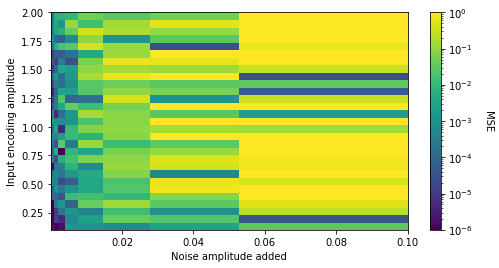

In [10]:
from matplotlib.colors import LogNorm
fig=plt.figure(figsize=[8,4])
c=plt.pcolor(noise_levels,amp_levels,error+1E-12,norm = LogNorm(vmin = 1E-6, vmax = 1)) 
cbar =fig.colorbar(c)
cbar.set_label('MSE', rotation=270,labelpad=20)
plt.xlabel('Noise amplitude added')
plt.ylabel('Input encoding amplitude')

Text(0.5, 0, 'Amp level')

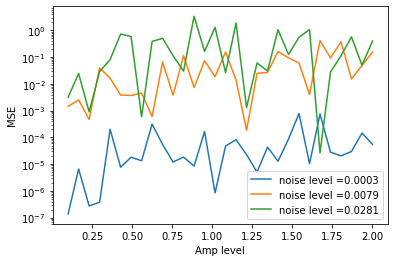

In [11]:

plt.semilogy(amp_levels,error[:,20],label='noise level =' +str('{0:.4f}'.format(noise_levels[20])))
plt.semilogy(amp_levels,error[:,25],label='noise level =' +str('{0:.4f}'.format(noise_levels[25])))
plt.semilogy(amp_levels,error[:,27],label='noise level =' +str('{0:.4f}'.format(noise_levels[27])))
plt.legend()
plt.ylabel('MSE')
plt.xlabel('Amp level')

This suggests that, for a precision of parameters of about 1%, the variation of the resulting trajectory grows approximately exponentially with the initial amplitude scale. It is preferable to keep the input amplitude scale below 1.

Now, let us examine varying the evolution time, Tmax

In [12]:
error = [] #store the error relative to the nominal true value 
amp_levels = np.linspace(0.1,2,10)
Tmaxs = np.linspace(0.1, 10, 30)

    # set initial angles (in rad)
x = torch.rand([1,4])*2 - 1

for Tmax in Tmaxs:
    pend = CoupledPendula(Tmax = Tmax)
    # simulate a chain of coupled pendula with the following parameters, which are kept fixed except the encoding amplitude
    ω0 = torch.tensor([10.,10.,10.,10.])
    ωd = torch.tensor([0.,0.,0.,0.])
    Ad = torch.tensor([0.,0.,0.,0.])
    v0 = torch.tensor([0.,0.,0.,0.])
    coupling = torch.tensor([10.,10.,10.,10.])
    γ = torch.tensor([0.0,0.0,0.0,0.0])
    encoding_amplitude = torch.tensor(1.)
    phid = torch.tensor([0.,0.,0.,0.])


    # propagate through setup
    yout = pend(x, ω0, ωd, Ad, v0, coupling, γ, encoding_amplitude, phid, full = True)

    noise_levels = 10**(np.linspace(-9,-1,30))
    youts= []
    for noise_level in noise_levels:
        ω0n = ω0 + torch.randn(ω0.shape)*noise_level
        youts.append(pend(x, ω0n, ωd, Ad, v0, coupling, γ, encoding_amplitude, phid, full = True).detach().cpu())

    yout0 = youts[0] #The reference evolution 
    for yout in youts:
        error.append(torch.sum(yout-yout0)**2) #Compute the mean-squared error of one pendulum's trajectory

In [13]:
error = np.array(error)
error = np.reshape(error,[30,30])

<ipython-input-14-bdf9410ac60c>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c=plt.pcolor(noise_levels,Tmaxs,error+1E-12,norm = LogNorm(vmin = 1E-6, vmax = 1))


Text(0, 0.5, 'Tmax')

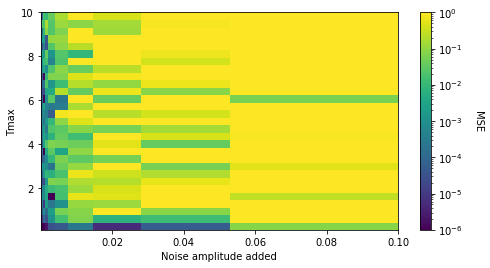

In [14]:
from matplotlib.colors import LogNorm
fig=plt.figure(figsize=[8,4])
c=plt.pcolor(noise_levels,Tmaxs,error+1E-12,norm = LogNorm(vmin = 1E-6, vmax = 1)) 
cbar =fig.colorbar(c)
cbar.set_label('MSE', rotation=270,labelpad=20)
plt.xlabel('Noise amplitude added')
plt.ylabel('Tmax')

Text(0.5, 0, 'Tmaxs')

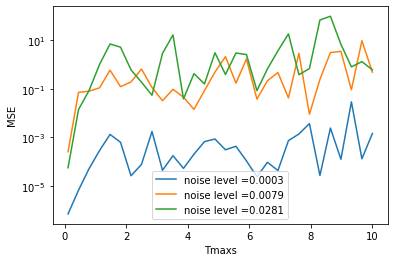

In [15]:
plt.semilogy(Tmaxs,error[:,20],label='noise level =' +str('{0:.4f}'.format(noise_levels[20])))
plt.semilogy(Tmaxs,error[:,25],label='noise level =' +str('{0:.4f}'.format(noise_levels[25])))
plt.semilogy(Tmaxs,error[:,27],label='noise level =' +str('{0:.4f}'.format(noise_levels[27])))
plt.legend()
plt.ylabel('MSE')
plt.xlabel('Tmaxs')

This suggests we can expect to evolve up to Tmax = 2, maybe Tmax = 4, before variation in parameters will lead to too many output fluctuations.

## Initialize experiment as a PNN module

### Without trainable parameters (only trainable inputs)

Now initialize the coupled pendula experiment as a PNN module:

In [16]:
from modules import ExpModule

## Train differentiable digital model

In [17]:
from model_architectures.DiscoverODEVariableParameters_miscal import DiscoverODEVariableParameters

Here, we assume that one has measured and calibrated the relationship between controllable experimental parameters and the parameters of the physical model (the coupling coefficients and resonant frequencies of the pendula, as well as in principle the damping rate and so on). 

We first show that if the initial calibration of parameters to their true experimental values is not accurate, a data-driven model can automatically learn this calibration.

To simulate this effect, we use a deliberately-wrong implementation of our DiscoverODEVariableParameters architecture in which the calibration transformation is initialized by a diagonal matrix whose elements differ from the identity matrix by 1%. We assume here that the calibration error is strictly linear. However, by including values within the parameterNunits parameter for the DiscoverODEVariableParameters initialization, it is possible to model calibrations in which the true experimental parameters are nonlinearly-related to the provided values. 



The digital model we use here is depicted in the figure below, where the ODE used is:

$$ \frac{d^2 \theta_n}{dt^2} = -\omega_{0n}^2\sin(\theta_n) + c_{n+1} \: (\theta_{n+1} - \theta_n) + c_{n} \: (\theta_{n-1} - \theta_n)$$
where $\omega_{0n}$ is the natural frequency of the $n$-th pendulum and $c_{n}$ is the coupling constant of the $n$-th pendulum to the $(n-1)$-th pendulum.

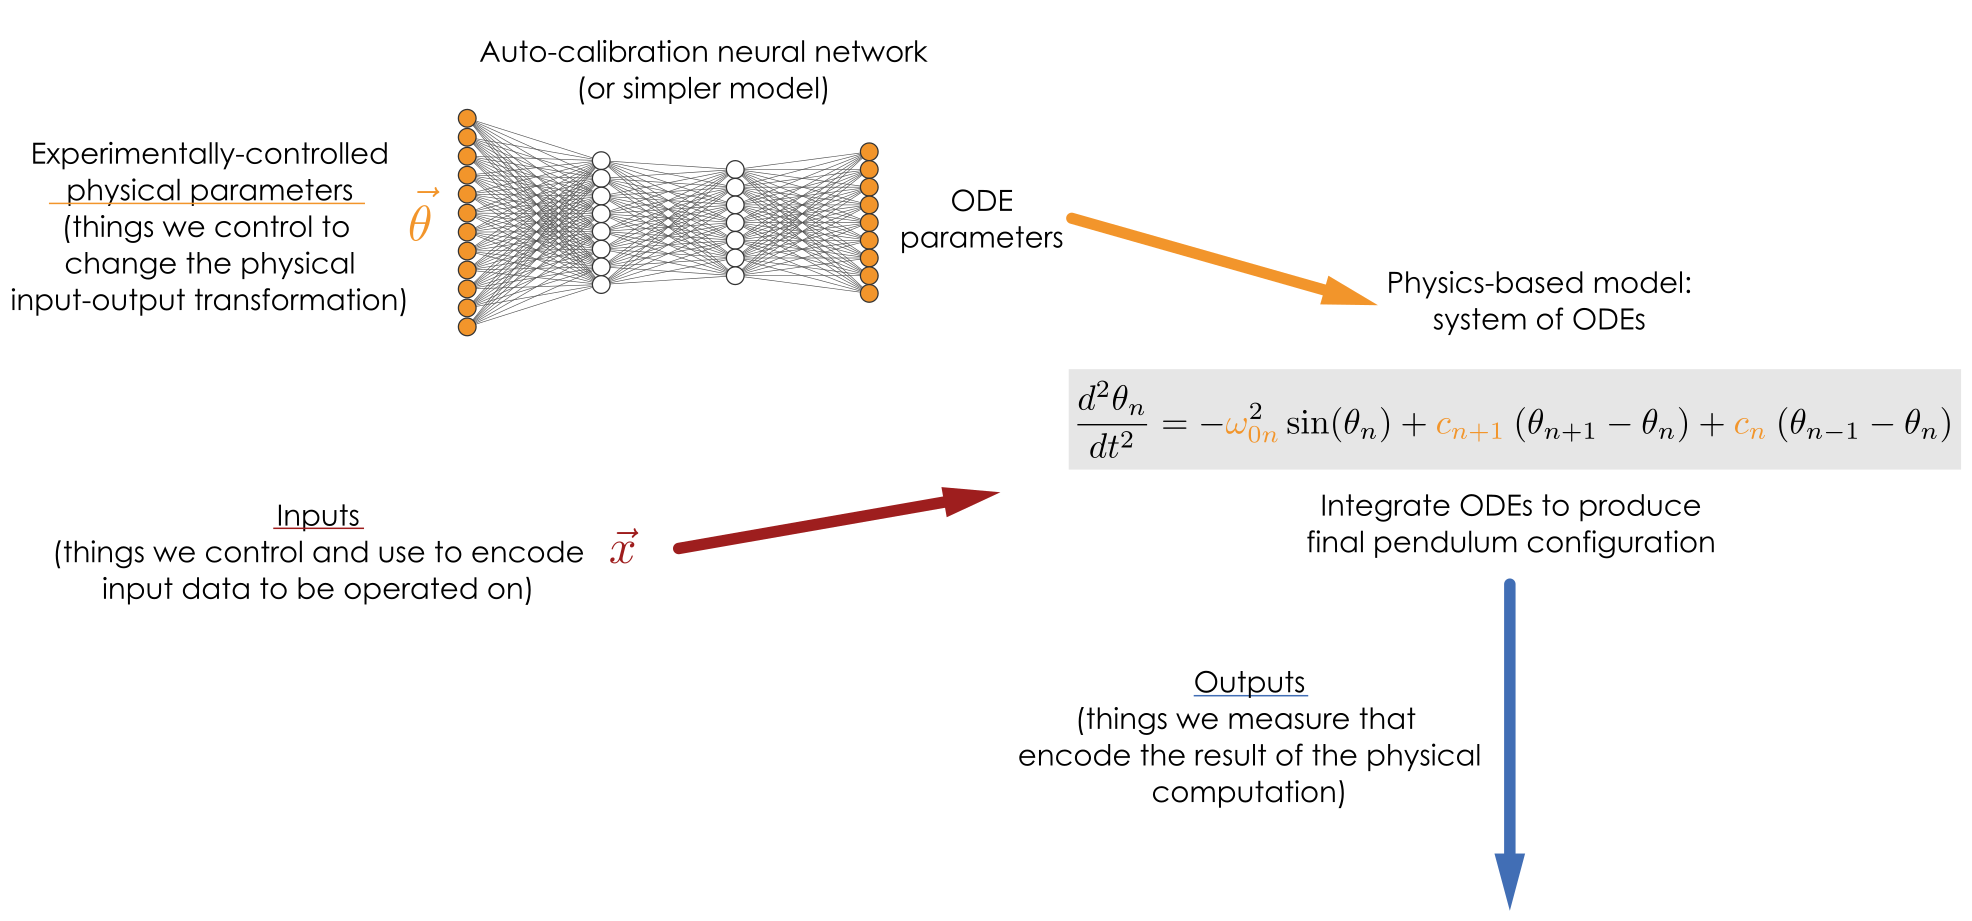

This module saves the shape of all parameters in params_reg and their allowed range in params_range. When trained as part of a neural network, the parameters are randomly initialized within the given range and will be kept within the range during training.

In [18]:
n_pendula = 48 # We choose this to be a multiple of the 12-dimensional input vectors we consider for the vowel formant classification task

pendulaargs = dict(
    Exp = CoupledPendula,
    # Inputs are encoded in the initial angles of pendule on the chain. Hence the
    # input dimension is equal to the number of pendula.
    input_dim = n_pendula, 
    # Similarly for the outputs, which correspond to the final angle of the pendula
    output_dim = n_pendula, 
    # We allow the initial angles to be in a range of -90deg to 90deg:
    input_range = [-np.pi,np.pi],
    # All hyperparameters and the fixed values they have need to be stored
    # in a dictionary called hparams. The names of the keys in the dictionary
    # need to correspond to the arguments of the experiment's __init__ function.
    # The pendula experiment only has one hyperparameter which is the simulation time.
    # We set it to 2 seconds:
    hparams = dict(
        Tmax = 4
    ),
    # params_reg is a parameter register that needs the names of
    # all parameters of the experiment and their respective dimension. 
    # The names of the keys in this dictionary need to correspond the arguments
    # of the experiment's __call__ function. 
    # The pendula experiment has some parameters like the natural frequency that 
    # can be adjusted for every single pendulum individually, so their dimension 
    # is equal to the number of pendula. Other parameters are just scalars and
    # their dimension is equal to one.
    params_reg = dict(
       ω0 = [n_pendula],
       ωd = [n_pendula],
       Ad = [n_pendula],
       v0 = [n_pendula],
       coupling = [n_pendula],
       γ = [n_pendula],
       encoding_amplitude = [1],
       phid = [1]),
    # params_range takes the experimentally allowable/realizeable range for each 
    # parameter as a list containing [lower bound, upper bound]. 
    # Bounds need to be set so that 1) during training the PNN does not 
    # produce parameters that are not experimentally realizable and 2) because the
    # differentiable digital model is usually only valid over a finite range of 
    # parameters.
    # By setting the lower bound equal to the upper bound, parameters are effectively
    # converted to hyperparameters and fixed at the respective value during training.
    params_range = {
       'ω0' : [10.,20.],
       'ωd' : [0.,0.],
       'Ad' : [0.,0.],
       'v0' : [0.,0.],
       'coupling' : [1., 20.],
       'γ' : [0., 0.],
       'encoding_amplitude' : [0.5, 0.5],
       'T' : [4,4],
       'phid' : [0,0]},
    device = device
)  

# To initialize the pendula as an ExpModule that can be used in a PNN, we pass
# all the above defined arguments to ExpModule.
# By default, the ExpModule loads a deep neural network as a differentiable 
# digital (or trains one if loading fails). The next section shows how to do this
# manually so we set load_dt to False to prevent the automatic training procedure.
pendula = ExpModule(**pendulaargs, load_dt = False)

In [19]:
# take data for digital twin
pendula.dt.take_dt_data(10000)

Saved data dt_data\CoupledPendula_mean_in48_out48_Tmax4_data.npz


Loaded data dt_data\CoupledPendula_mean_in48_out48_Tmax4_data.npz
Epoch: 1, 	 Train loss: 0.11, 	 Test loss: 0.09
Epoch: 2, 	 Train loss: 0.05, 	 Test loss: 0.04
Epoch: 3, 	 Train loss: 0.04, 	 Test loss: 0.02
Epoch: 4, 	 Train loss: 0.03, 	 Test loss: 0.01
Epoch: 5, 	 Train loss: 0.01, 	 Test loss: 0.01
Epoch: 6, 	 Train loss: 0.01, 	 Test loss: 0.01
Epoch: 7, 	 Train loss: 0.01, 	 Test loss: 0.01
Epoch: 8, 	 Train loss: 0.01, 	 Test loss: 0.01
Epoch: 9, 	 Train loss: 0.01, 	 Test loss: 0.01
Epoch: 10, 	 Train loss: 0.01, 	 Test loss: 0.01
Trained digital twin and saved at  dt_models\CoupledPendula_mean_in48_out48_Tmax4.p


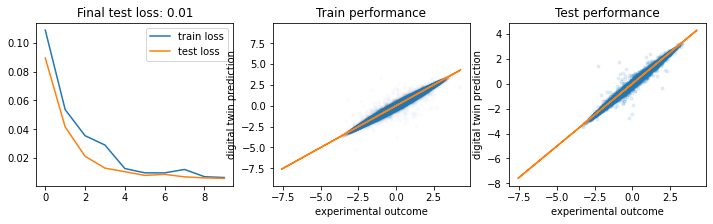

In [20]:
#below was with intialized omega0, coupling at correct values 
pendula.dt.train_mean_dt(
    Model = DiscoverODEVariableParameters,
    lr = 1E-4,
    epochs = 10,
    A = pendula.dt.A,
    B = pendula.dt.B,
    input_range = pendula.input_range,
    params_range = pendula.params_range,
    nODEcoefficients = pendula.ntrainableparams,
    parameterNunits = [], #If the NoCoupling below is False, this implements a NN that maps our controls to the ODE parameters. If numbers are put into this such as [100,100], the network is a multi-layer NN. If it is empty, the network is a linear layer
    NoCouplingInParameterNet = True, #This assumes that each ODE parameter is related to an input control parameter by a 1:1 relationship. 
    ODEtmax =4.,
    ODEtimesteps = 60,
    encoding_amplitude=0.5)

### (Optional) Test digital twin on unseen data:

In [21]:
x = torch.FloatTensor(1000, pendula.input_dim).uniform_(*pendula.input_range).to(device)

with torch.no_grad():
    yexp = pendula(x).cpu()
    ypred = pendula.dt_physical(x).cpu()
    

In [22]:
def plot_dt_exp_comparison(yexp, ypred, index1 = 0, index2 = 1, module = None):
    plt.figure(figsize = [10,4], dpi = 100)

    plt.subplot(1,2,1)
    plt.plot(yexp.flatten(), ypred.flatten(), '.', alpha = 0.01)
    plt.plot(yexp.flatten(), yexp.flatten(), '-')
    plt.xlabel('experimental outcome')
    plt.ylabel('digital twin prediction')
    plt.title('All experimental outcomes vs predictions')
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(ypred[index1], '.-', lw = 1, c = 'b', alpha = 0.5, label = 'digital twin prediction')
    plt.plot(yexp[index1], 'x-', lw = 1, c = 'b', alpha = 0.5, label = 'experimental outcome')
    plt.plot(ypred[index2], '.-', lw = 1, c = 'r', alpha = 0.5)
    plt.plot(yexp[index2], 'x-', lw = 1, c = 'r', alpha = 0.5)
    plt.legend()
    if module:
        plt.ylim(module.dt.B - 3*module.dt.A, module.dt.B + 3 * module.dt.A)
    plt.xlabel('output index')
    plt.ylabel('output value')
    plt.title(f'Outputs from index {index1} and {index2}')
    plt.grid()
    
    plt.savefig('img/coupled_pendula_dt_performance.png')
    plt.show()

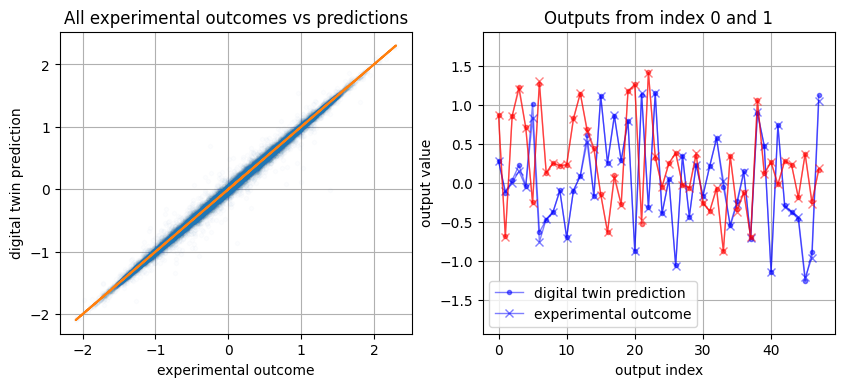

In [23]:
plot_dt_exp_comparison(yexp, ypred, module = pendula)

## Define PNN module

In [24]:
# this module contains the pnn.Module, a subclass of nn.Module that takes care
# of keeping trainable parameters within their limits
import pnn 

In [25]:
class PendulumNet(pnn.Module):
    '''
    This class represents the Physical Neural Network. It registers all
    PNN and regular pytorch modules.
    '''
    def __init__(self):
        super(pnn.Module, self).__init__()
        
        # n_pendula and pendulaargs are the variables we have defined above when 
        # training the differentiable digital model
        self.dim = n_pendula
        self.pendula1 = ExpModule(**pendulaargs, load_dt = True)
        self.pendula1.params['ω0'].data = torch.tensor(torch.ones(48)*15) #We initialize these trainable parameters
        self.pendula1.params['coupling'].data = torch.tensor(torch.ones(48)*15) #Initializing these values as constants is not actually optimal in our experience
        self.pendula2 = ExpModule(**pendulaargs, load_dt = True)                #, but it helps make the visualizations of training clearer. For performance, we find a more heterogeneous initial condiiton is usually better
        self.pendula2.params['ω0'].data = torch.tensor(torch.ones(48)*15)
        self.pendula2.params['coupling'].data = torch.tensor(torch.ones(48)*15)

        # to define and rescale decision boundary
        self.scaling = nn.Parameter(torch.tensor(1., device = device), requires_grad=True)
        self.offset = nn.Parameter(torch.tensor(0., device = device), requires_grad=True)
        # to translate whatever scale the data is in to the allowed scale of the physical system
        self.scalingi = nn.Parameter(torch.tensor(1., device = device), requires_grad=True)
        self.offseti = nn.Parameter(torch.tensor(0., device = device), requires_grad=True)       
        self.param_buffer = []
        

    def forward(self, x):
        batch_size = x.shape[0]
        
        x=x*self.scalingi+self.offseti
        x = self.pendula1(torch.cat((x,x,x,x),dim=1)) #Repeat the input 12-D vector 4 times
        x = self.pendula2(x)
  
        xout = x[:,[4,11,18,27,34,39,45]] #This is somewhat arbitrary - I tried to choose 7 pendula that were roughly evenly spaced but not exactly

        output = F.log_softmax(xout*self.scaling+self.offset, dim=1)
        return output
    
    def save_params(self):
        # create copy of parameters
        params = dict(self.pendula.params)
        # move all parameters to cpu
        for key, val in params.items():
            params[key] = val.cpu().detach()
        # save in buffer
        self.param_buffer.append(params)

## Train PNN module

### Initialize simple dataset

In [42]:
dataset= torch.load('data/vowels_dataset.p') 
#This is from https://homepages.wmich.edu/~hillenbr/voweldata.html 
#We are just using 

In [27]:
train_loader = torch.utils.data.DataLoader(dataset=dataset['train_dataset'],batch_size=50)
test_loader = torch.utils.data.DataLoader(dataset=dataset['test_dataset'],batch_size=50)

It can take some time (up to hours depending on your machine) to run the training, so you can skip it by setting the variable below to False

In [28]:
Run_Training = True

### Initialize model, optimizer and scheduler

Set variables for training and initialize optimizers and model:

In [29]:
epochs = 250
# log_interval determines after how many batches the losses are logged
log_interval = 1
lr = 1

In [33]:
model = PendulumNet().to(device)

optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=125, gamma=0.5)

Loaded digital twin  dt_models\CoupledPendula_mean_in48_out48_Tmax4.p
Loaded digital twin  dt_models\CoupledPendula_mean_in48_out48_Tmax4.p


<ipython-input-25-ce1c95fcbd41>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pendula1.params['ω0'].data = torch.tensor(torch.ones(48)*15) #We initialize these trainable parameters
<ipython-input-25-ce1c95fcbd41>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pendula1.params['coupling'].data = torch.tensor(torch.ones(48)*15) #Initializing these values as constants is not actually optimal in our experience
<ipython-input-25-ce1c95fcbd41>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pendula2.params['ω0'].data = to

In [34]:
model_by_step = []

batch_idx_ls = []
acc_ls = []
cr_loss_ls = []
lg_loss_ls = []
test_ls = []
test_accs = []

### Training loop

In [35]:
if Run_Training:
    for epoch in range(1, epochs + 1):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)

            # the only addition to a conventional pytorch training loop is the lagrangian loss term
            # that keeps parameters and inputs within the user-defined ranges
            lg_loss = model.pnnlagrangian()
            cr_loss = F.nll_loss(output, target)
            loss = lg_loss + cr_loss

            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                batch_idx_ls.append(epoch + batch_idx / len(train_loader))
                cr_loss_ls.append(cr_loss)
                lg_loss_ls.append(lg_loss)
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct = pred.eq(target.view_as(pred)).sum().item()
                acc_ls.append(correct / len(target))

                # save the current state dict to later visualize training
                model_by_step.append(pnn.get_cpu_state_dict(model))

        test_loss, acc = model.test_epoch(device, test_loader)
        scheduler.step()
        test_ls.append(test_loss)
        test_accs.append(acc)
        print(f'Finished epoch {epoch} with test loss {test_loss:.2f} and accuracy {int(acc*100)}.')

    # The warning is discussed here and seems to be an issue that is fixed in pytorch 1.8 but not in
    # pytorch 1.7.1
    # https://github.com/pytorch/pytorch/issues/46983

Finished epoch 1 with test loss 1.94 and accuracy 18.
Finished epoch 2 with test loss 1.94 and accuracy 28.
Finished epoch 3 with test loss 1.93 and accuracy 38.
Finished epoch 4 with test loss 1.93 and accuracy 38.
Finished epoch 5 with test loss 1.93 and accuracy 34.
Finished epoch 6 with test loss 1.92 and accuracy 30.
Finished epoch 7 with test loss 1.92 and accuracy 30.
Finished epoch 8 with test loss 1.91 and accuracy 30.
Finished epoch 9 with test loss 1.91 and accuracy 32.
Finished epoch 10 with test loss 1.90 and accuracy 32.
Finished epoch 11 with test loss 1.89 and accuracy 32.
Finished epoch 12 with test loss 1.88 and accuracy 32.
Finished epoch 13 with test loss 1.88 and accuracy 32.
Finished epoch 14 with test loss 1.87 and accuracy 32.
Finished epoch 15 with test loss 1.85 and accuracy 36.
Finished epoch 16 with test loss 1.84 and accuracy 40.
Finished epoch 17 with test loss 1.81 and accuracy 38.
Finished epoch 18 with test loss 1.79 and accuracy 38.
Finished epoch 19 w

Finished epoch 150 with test loss 0.44 and accuracy 93.
Finished epoch 151 with test loss 0.44 and accuracy 93.
Finished epoch 152 with test loss 0.44 and accuracy 93.
Finished epoch 153 with test loss 0.44 and accuracy 93.
Finished epoch 154 with test loss 0.44 and accuracy 93.
Finished epoch 155 with test loss 0.44 and accuracy 93.
Finished epoch 156 with test loss 0.44 and accuracy 93.
Finished epoch 157 with test loss 0.44 and accuracy 93.
Finished epoch 158 with test loss 0.44 and accuracy 93.
Finished epoch 159 with test loss 0.44 and accuracy 93.
Finished epoch 160 with test loss 0.44 and accuracy 93.
Finished epoch 161 with test loss 0.44 and accuracy 93.
Finished epoch 162 with test loss 0.44 and accuracy 93.
Finished epoch 163 with test loss 0.44 and accuracy 93.
Finished epoch 164 with test loss 0.44 and accuracy 93.
Finished epoch 165 with test loss 0.44 and accuracy 93.
Finished epoch 166 with test loss 0.44 and accuracy 93.
Finished epoch 167 with test loss 0.44 and accur

In [36]:
if Run_Training==False:
    old_data = torch.load('data/Training Result for Vowel Coupled Pendula Example.p')
    model_by_step = old_data['model_by_step']
    steps = old_data['steps']
    nsteps = old_data['nsteps']
    cr_loss_ls = old_data['cr_loss_ls']
    lg_loss_ls = old_data['lg_loss_ls']
    test_ls = old_data['test_ls']
    test_accs = old_data['test_accs']    
    

## Visualize results

First, we'll just look at the simple training curves of loss and accuracy

Text(0.5, 1.0, 'Test accuracy over epoch')

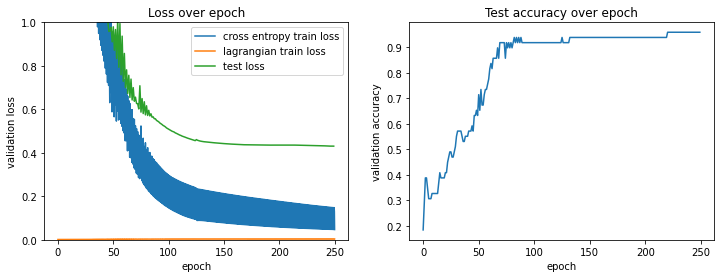

In [37]:
if Run_Training:
    steps = torch.arange(0, epochs, 1/len(train_loader)/log_interval)
    nsteps = epochs * len(train_loader) / log_interval
    
plt.figure(figsize = [12,4])

plt.subplot(1,2,1)
plt.plot(steps, cr_loss_ls, label = 'cross entropy train loss')
plt.plot(steps, lg_loss_ls, label = 'lagrangian train loss')
plt.plot(test_ls, label = 'test loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('validation loss')
plt.title('Loss over epoch')
plt.ylim(0, 1)

plt.subplot(1,2,2)
plt.plot(test_accs)
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('Test accuracy over epoch')

Next, let us look at how the physical parameters of the system - the coupling coefficients and resonant frequencies - changed during training

In [38]:
total_steps=len(model_by_step)

In [39]:
omega0_1=[]
omega0_2=[]
kappa_1=[]
kappa_2=[]
for current_model in model_by_step:
    omega0_1.append(current_model['pendula1.params.ω0'].detach().cpu().numpy())
    omega0_2.append(current_model['pendula2.params.ω0'].detach().cpu().numpy())  
    kappa_1.append(current_model['pendula1.params.coupling'].detach().cpu().numpy())  
    kappa_2.append(current_model['pendula2.params.coupling'].detach().cpu().numpy())    
    

<ipython-input-40-e7d2b4012d16>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c=plt.pcolor(steps,np.arange(omega0_1.shape[1]),omega0_1.T)
<ipython-input-40-e7d2b4012d16>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c=plt.pcolor(steps,np.arange(omega0_2.shape[1]),omega0_2.T)
<ipython-input-40-e7d2b4012d16>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of

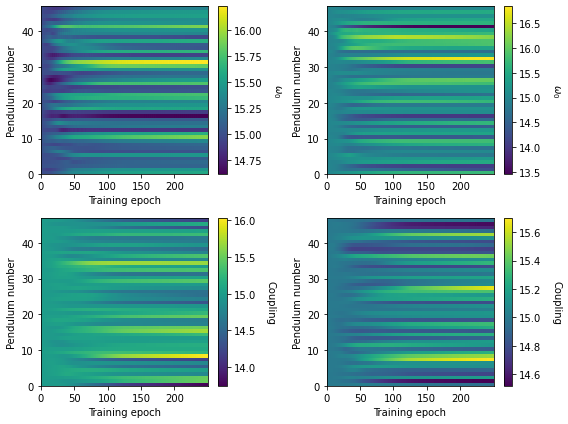

In [40]:
omega0_1=np.array(omega0_1)

fig=plt.figure(figsize=[8,6])
plt.subplot(2,2,1)
omega0_1=np.array(omega0_1)
c=plt.pcolor(steps,np.arange(omega0_1.shape[1]),omega0_1.T)
cbar =plt.colorbar(c)
cbar.set_label(r'$ω_0$', rotation=270,labelpad=20)
plt.xlabel('Training epoch')
plt.ylabel('Pendulum number')

plt.subplot(2,2,2)
omega0_2=np.array(omega0_2)
c=plt.pcolor(steps,np.arange(omega0_2.shape[1]),omega0_2.T)
cbar =plt.colorbar(c)
cbar.set_label(r'$ω_0$', rotation=270,labelpad=20)
plt.xlabel('Training epoch')
plt.ylabel('Pendulum number')

plt.subplot(2,2,3)
kappa_1=np.array(kappa_1)
c=plt.pcolor(steps,np.arange(kappa_1.shape[1]),kappa_1.T)
cbar =plt.colorbar(c)
cbar.set_label('Coupling', rotation=270,labelpad=20)
plt.xlabel('Training epoch')
plt.ylabel('Pendulum number')

plt.subplot(2,2,4)
kappa_2=np.array(kappa_2)
c=plt.pcolor(steps,np.arange(kappa_2.shape[1]),kappa_2.T)
cbar =plt.colorbar(c)
cbar.set_label('Coupling', rotation=270,labelpad=20)
plt.xlabel('Training epoch')
plt.ylabel('Pendulum number')

fig.tight_layout()

In [41]:
if Run_Training:
    save_dict = dict(model_by_step=model_by_step,steps=steps,nsteps=nsteps,cr_loss_ls = cr_loss_ls,lg_loss_ls=lg_loss_ls,test_ls = test_ls, test_accs=test_accs) 
    fnamec = 'data/Training Result for Vowel Coupled Pendula Example.p'
    save_data = torch.save(save_dict, fnamec)

In [59]:
ypred_train = model(dataset['train_dataset'][:][0].to(model.pendula1.device))
ypred_test = model(dataset['test_dataset'][:][0].to(model.pendula1.device))

In [74]:
ypred = torch.cat((ypred_train.argmax(dim = -1), ypred_test.argmax(dim = -1))).cpu()
y = torch.cat((dataset['train_dataset'][:][1], dataset['test_dataset'][:][1]))

<ipython-input-111-14452cec4bdf>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+alpha)
<ipython-input-111-14452cec4bdf>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+alpha)


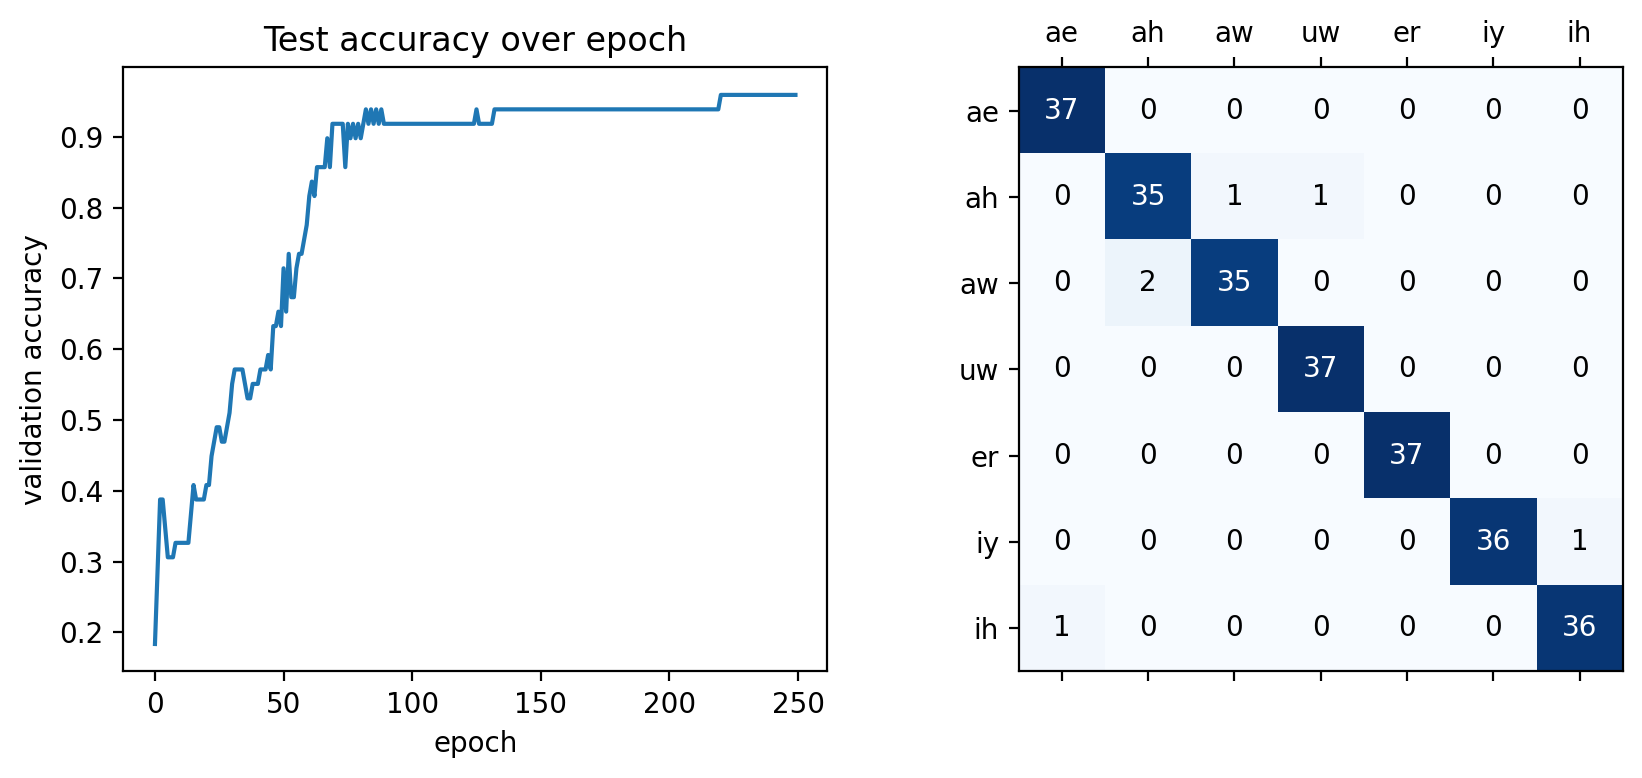

In [111]:
fig = plt.figure(figsize = [10,4], dpi = 200)

ax1 = fig.add_subplot(121)
ax1.plot(test_accs)
plt.xlabel('epoch')
plt.ylabel('validation accuracy')
plt.title('Test accuracy over epoch')

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
conf_mat = confusion_matrix(y, ypred, labels=[0,1,2,3,4,5,6])#["ae", "ah", "aw", "uw", "er", "iy", "ih"])

alpha = ["ae", "ah", "aw", "uw", "er", "iy", "ih"]

ax = fig.add_subplot(122)
cax = ax.matshow(conf_mat, interpolation='nearest', cmap = cm.Blues)
#fig.colorbar(cax)

ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)

for (i, j), z in np.ndenumerate(conf_mat):
    ax.text(j, i, '{:d}'.format(z), ha='center', va='center', color = 'white' if i == j else 'black')

plt.show()